In [ ]:
!pip install -q git+https://github.com/THU-MIG/yoloe.git
!pip install -q git+https://github.com/THU-MIG/yoloe.git#subdirectory=third_party/CLIP
!pip install -q git+https://github.com/THU-MIG/yoloe.git#subdirectory=third_party/ml-mobileclip
!pip install -q git+https://github.com/THU-MIG/yoloe.git#subdirectory=third_party/lvis-api
!pip install -q roboflow supervision

!wget -q https://docs-assets.developer.apple.com/ml-research/datasets/mobileclip/mobileclip_blt.pt

  Cloning https://github.com/THU-MIG/yoloe.git to /tmp/pip-req-build-sja4u52r
  Running command git clone --filter=blob:none --quiet https://github.com/THU-MIG/yoloe.git /tmp/pip-req-build-sja4u52r
  Resolved https://github.com/THU-MIG/yoloe.git to commit 0c07e70b1d257989fe71660a8f6ee26d00e19adb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━

In [ ]:
from huggingface_hub import hf_hub_download

path = hf_hub_download(repo_id="jameslahm/yoloe", filename="yoloe-v8l-seg.pt", local_dir='.')
path = hf_hub_download(repo_id="jameslahm/yoloe", filename="yoloe-v8l-seg-pf.pt", local_dir='.')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


yoloe-v8l-seg.pt:   0%|          | 0.00/107M [00:00<?, ?B/s]

yoloe-v8l-seg-pf.pt:   0%|          | 0.00/103M [00:00<?, ?B/s]

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Download dataset from Roboflow Universe

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install -q roboflow

from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')

rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace("selencakmak").project("tumor-dj2a1")
version = project.version(1)
dataset = version.download("yolov8")

mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets
loading Roboflow workspace...
loading Roboflow project...


**NOTE:**
Make sure the last 4 lines of the data.yaml file have the following format:

```
test: ../test/images
train: ../train/images
val: ../valid/images
```

If using a dataset from Roboflow, run the command below. 👇🏻

In [ ]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

## Linear Probing Or Full Tuning



In [ ]:
# True for Linear Probing and False for Full Tuning
# For fine tuning, YOLOE is exactly the same as YOLOv8 or YOLO11
USE_LINEAR_PROBING = True
project_name = "runs/lp" if USE_LINEAR_PROBING else "runs/ft"
lr0 = 1e-2 if USE_LINEAR_PROBING else 1e-3

In [ ]:
%cd {HOME}

from ultralytics import YOLOE
from ultralytics.models.yolo.yoloe.train_pe import YOLOEPETrainer, YOLOEPESegTrainer
import os
from ultralytics.nn.tasks import guess_model_scale
from ultralytics.utils import yaml_load, LOGGER
import torch

os.environ["PYTHONHASHSEED"] = "0"

data = "/content/datasets/Tumor-1/data.yaml"

model = YOLOE("yoloe-v8l.yaml")
del model.model.model[-1].savpe
model.load("yoloe-v8l-seg.pt")
model.eval()

# Ensure pe is set for classes
names = yaml_load(data)['names']
# You can also use visual prompt embedding for labels
tpe = model.get_text_pe(names)
pe_path = "tumor-pe.pt"
torch.save({"names": names, "pe": tpe}, pe_path)

if USE_LINEAR_PROBING:
  head_index = len(model.model.model) - 1
  freeze = [str(f) for f in range(0, head_index)]
  for name, child in model.model.model[-1].named_children():
      if 'cv3' not in name:
          freeze.append(f"{head_index}.{name}")

  freeze.extend([f"{head_index}.cv3.0.0", f"{head_index}.cv3.0.1", f"{head_index}.cv3.1.0", f"{head_index}.cv3.1.1", f"{head_index}.cv3.2.0", f"{head_index}.cv3.2.1"])
else:
  freeze = None

# Note that the printed parameters and FLOPS in YOLOe-v8l summary are not accurate because
# in YOLOe-v8l summary, the model is not reparameterized and the savpe of head is not removed.
# For the fine-tuned model, it is reparameterized and the savpe is removed, and it is exactly
# the same as YOLOv8-l, with zero overhead for fine tuning and inference.
results = model.train(data=data, epochs=5, close_mosaic=5, batch=16,
            optimizer='AdamW', lr0=lr0, warmup_bias_lr=0.0, \
            weight_decay=0.025, momentum=0.9, workers=4, \
            device="0", val_interval=1, project=project_name, \
            trainer=YOLOEPETrainer, freeze=freeze, train_pe_path=pe_path)

/content
Transferred 620/620 items from pretrained weights
Build text model mobileclip:blt
New https://pypi.org/project/ultralytics/8.3.90 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.39 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yoloe-v8l.yaml, data=/content/datasets/Tumor-1/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=4, project=runs/lp, name=train3, exist_ok=False, pretrained=yoloe-v8l-seg.pt, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=5, resume=False, amp=True, fraction=1.0, profile=False, freeze=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22.cv2', '22.dfl', '22.cv4', '22.reprta', '22.cv3.0.0', '22.cv3.0.1', '22.cv3.1.0', '22.cv3.1.1', '22.cv3.2.0', '22.cv3.2.1'],

train: Scanning /content/datasets/Tumor-1/train/labels.cache... 1047 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1047/1047 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/datasets/Tumor-1/valid/labels.cache... 299 images, 0 backgrounds, 0 corrupt: 100%|██████████| 299/299 [00:00<?, ?it/s]


Plotting labels to runs/lp/train3/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.025), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/lp/train3
Starting training for 5 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.36G      1.089       2.44      1.631          8        640: 100%|██████████| 66/66 [00:24<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  3.05it/s]



                   all        299        311      0.598      0.592      0.637      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.81G      1.078      1.209      1.622          7        640: 100%|██████████| 66/66 [00:20<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  3.04it/s]



                   all        299        311      0.817       0.63      0.762       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.74G      1.083      1.069      1.614          7        640: 100%|██████████| 66/66 [00:20<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.93it/s]



                   all        299        311       0.77      0.688      0.786      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      1.72G      1.082      1.014      1.615          7        640: 100%|██████████| 66/66 [00:20<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.93it/s]



                   all        299        311      0.768      0.698      0.794      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5       1.7G      1.089      1.017      1.635          7        640: 100%|██████████| 66/66 [00:20<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.99it/s]



                   all        299        311      0.806      0.682      0.794      0.546



5 epochs completed in 0.055 hours.
Optimizer stripped from runs/lp/train3/weights/last.pt, 87.6MB
Optimizer stripped from runs/lp/train3/weights/best.pt, 87.6MB

Validating runs/lp/train3/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.39 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOe-v8l summary (fused): 273 layers, 43,607,379 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.73it/s]




                   all        299        311      0.769      0.698      0.794      0.546
Speed: 0.2ms preprocess, 16.6ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/lp/train3


In [ ]:
RUNS = f"{project_name}/train"

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!ls {HOME}/{RUNS}

args.yaml					   PR_curve.png		  val_batch0_pred.jpg
confusion_matrix_normalized.png			   R_curve.png		  val_batch1_labels.jpg
confusion_matrix.png				   results.csv		  val_batch1_pred.jpg
events.out.tfevents.1741955426.c68c7ba30a8d.181.0  results.png		  val_batch2_labels.jpg
F1_curve.png					   train_batch0.jpg	  val_batch2_pred.jpg
labels_correlogram.jpg				   train_batch1.jpg	  weights
labels.jpg					   train_batch2.jpg
P_curve.png					   val_batch0_labels.jpg


/content


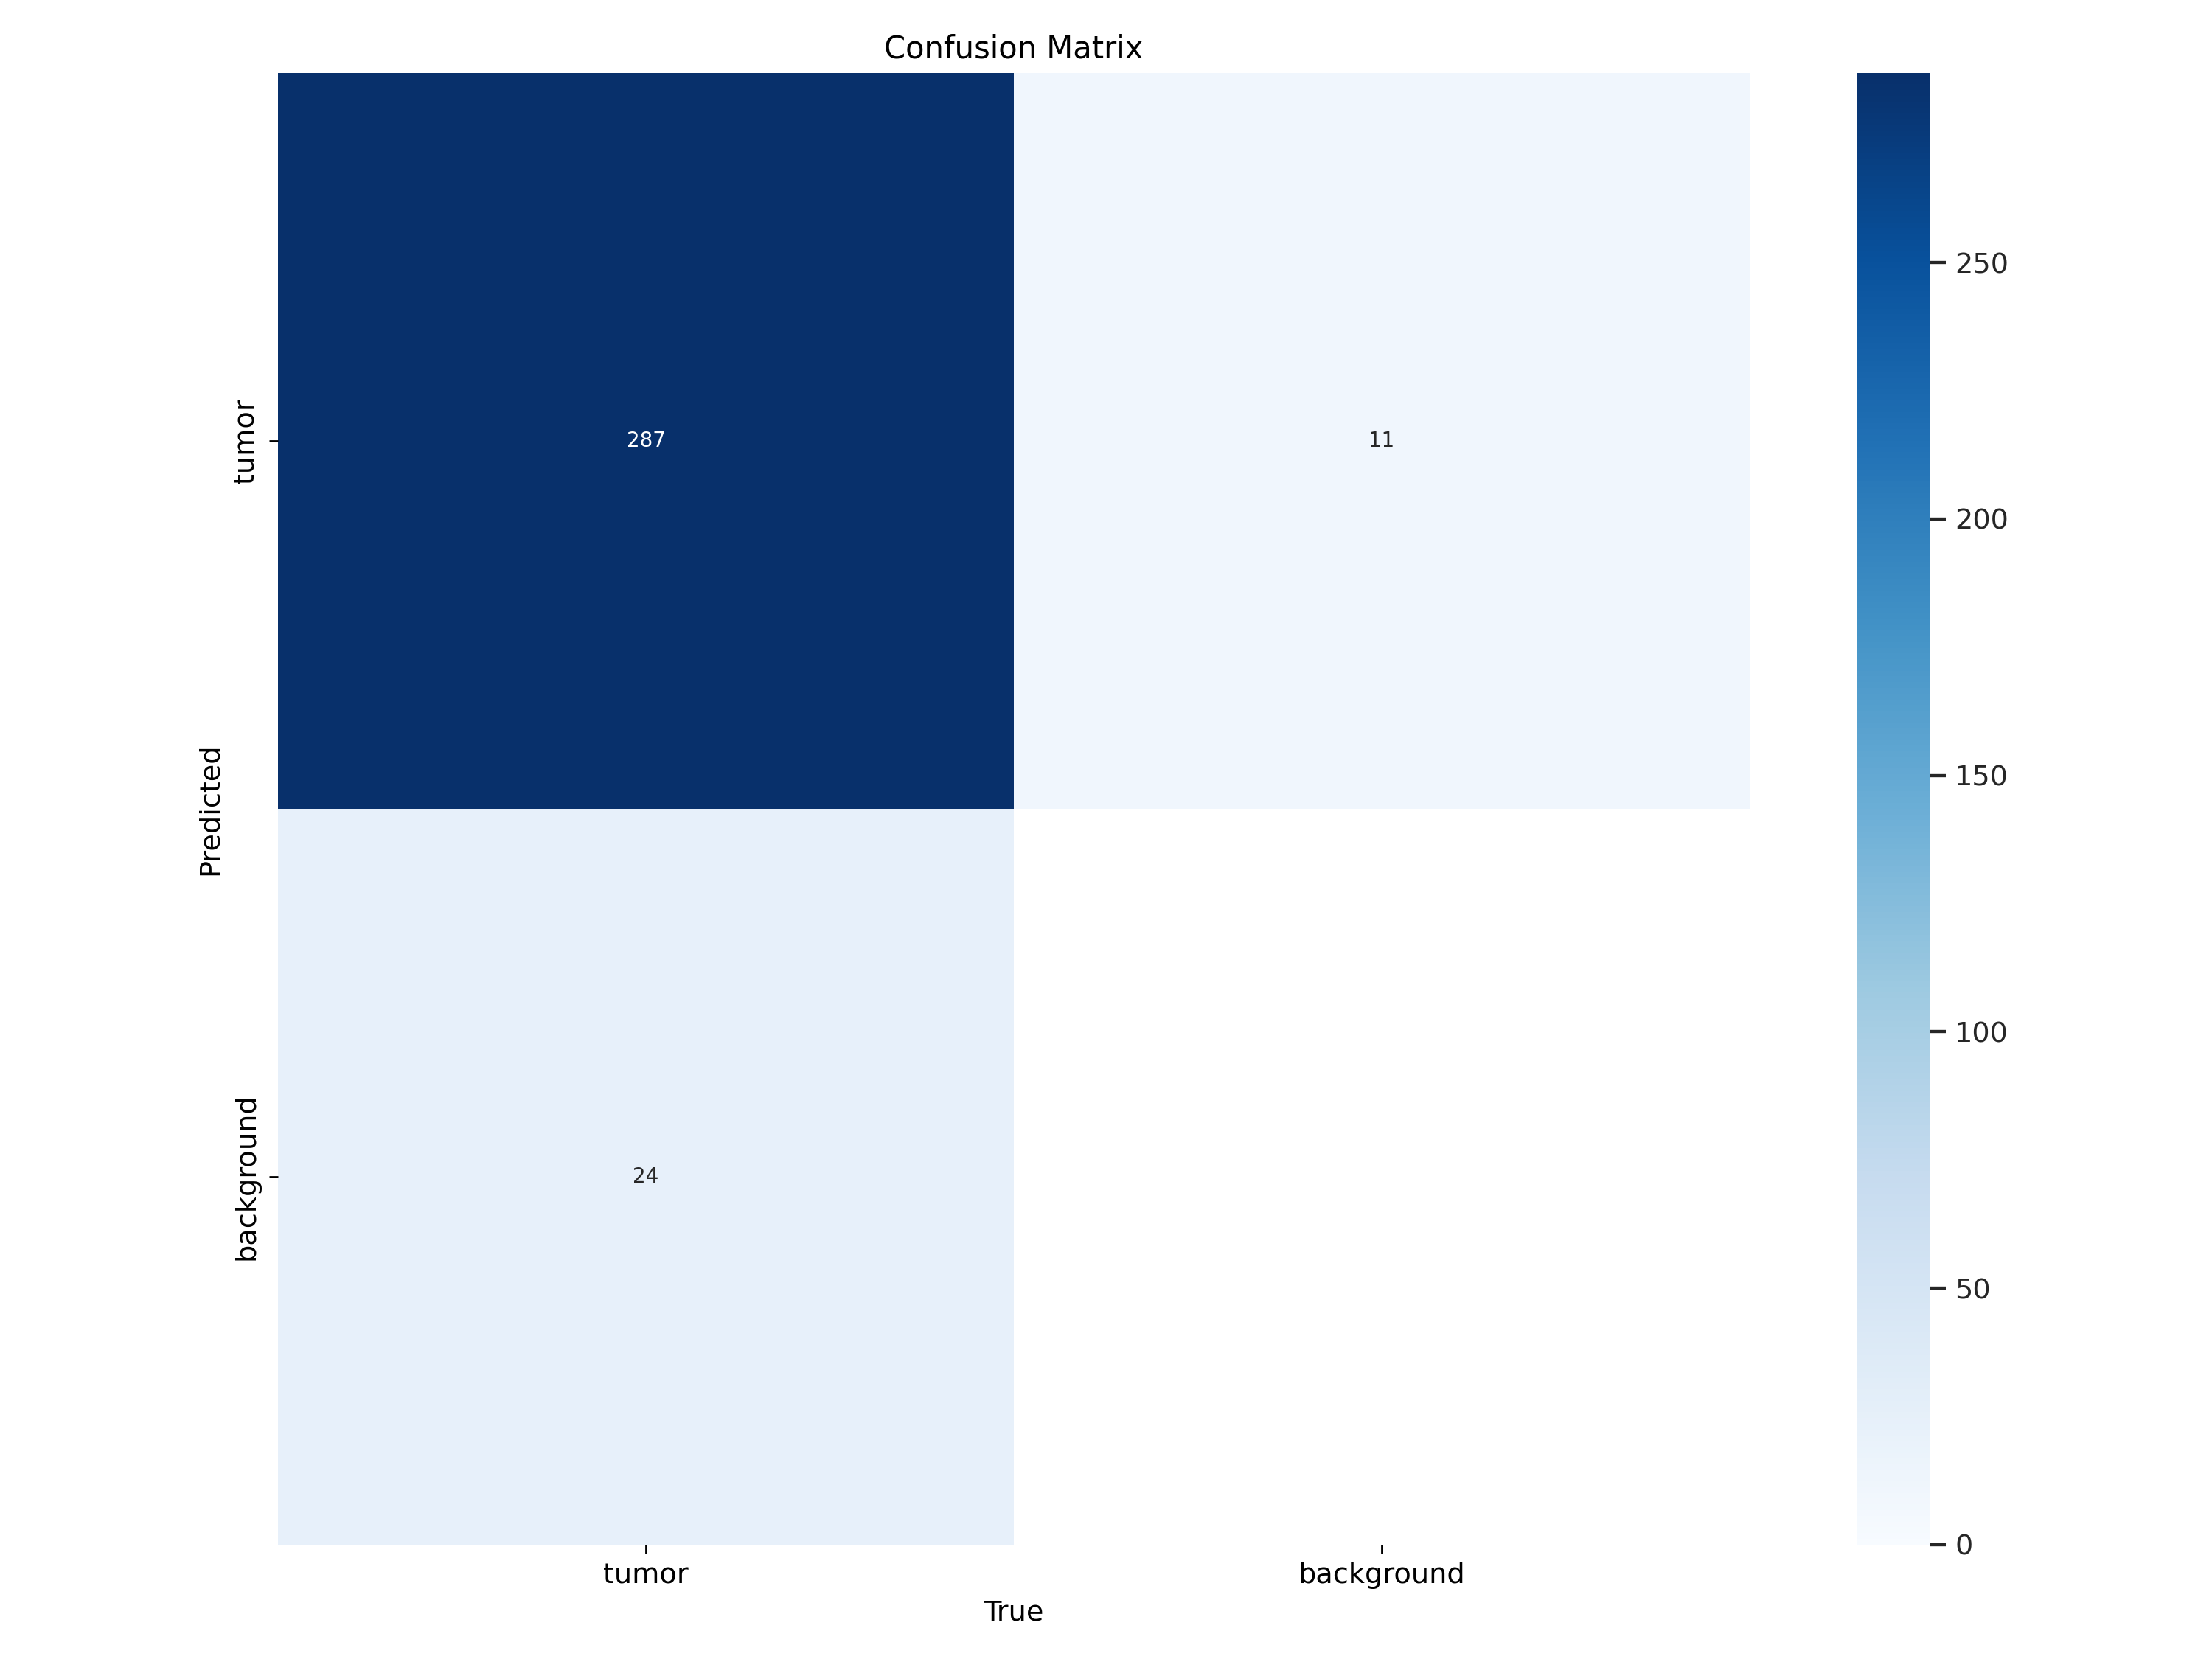

In [ ]:
%cd {HOME}
from IPython.display import Image
Image(filename=f'{HOME}/{RUNS}/confusion_matrix.png', width=600)

/content


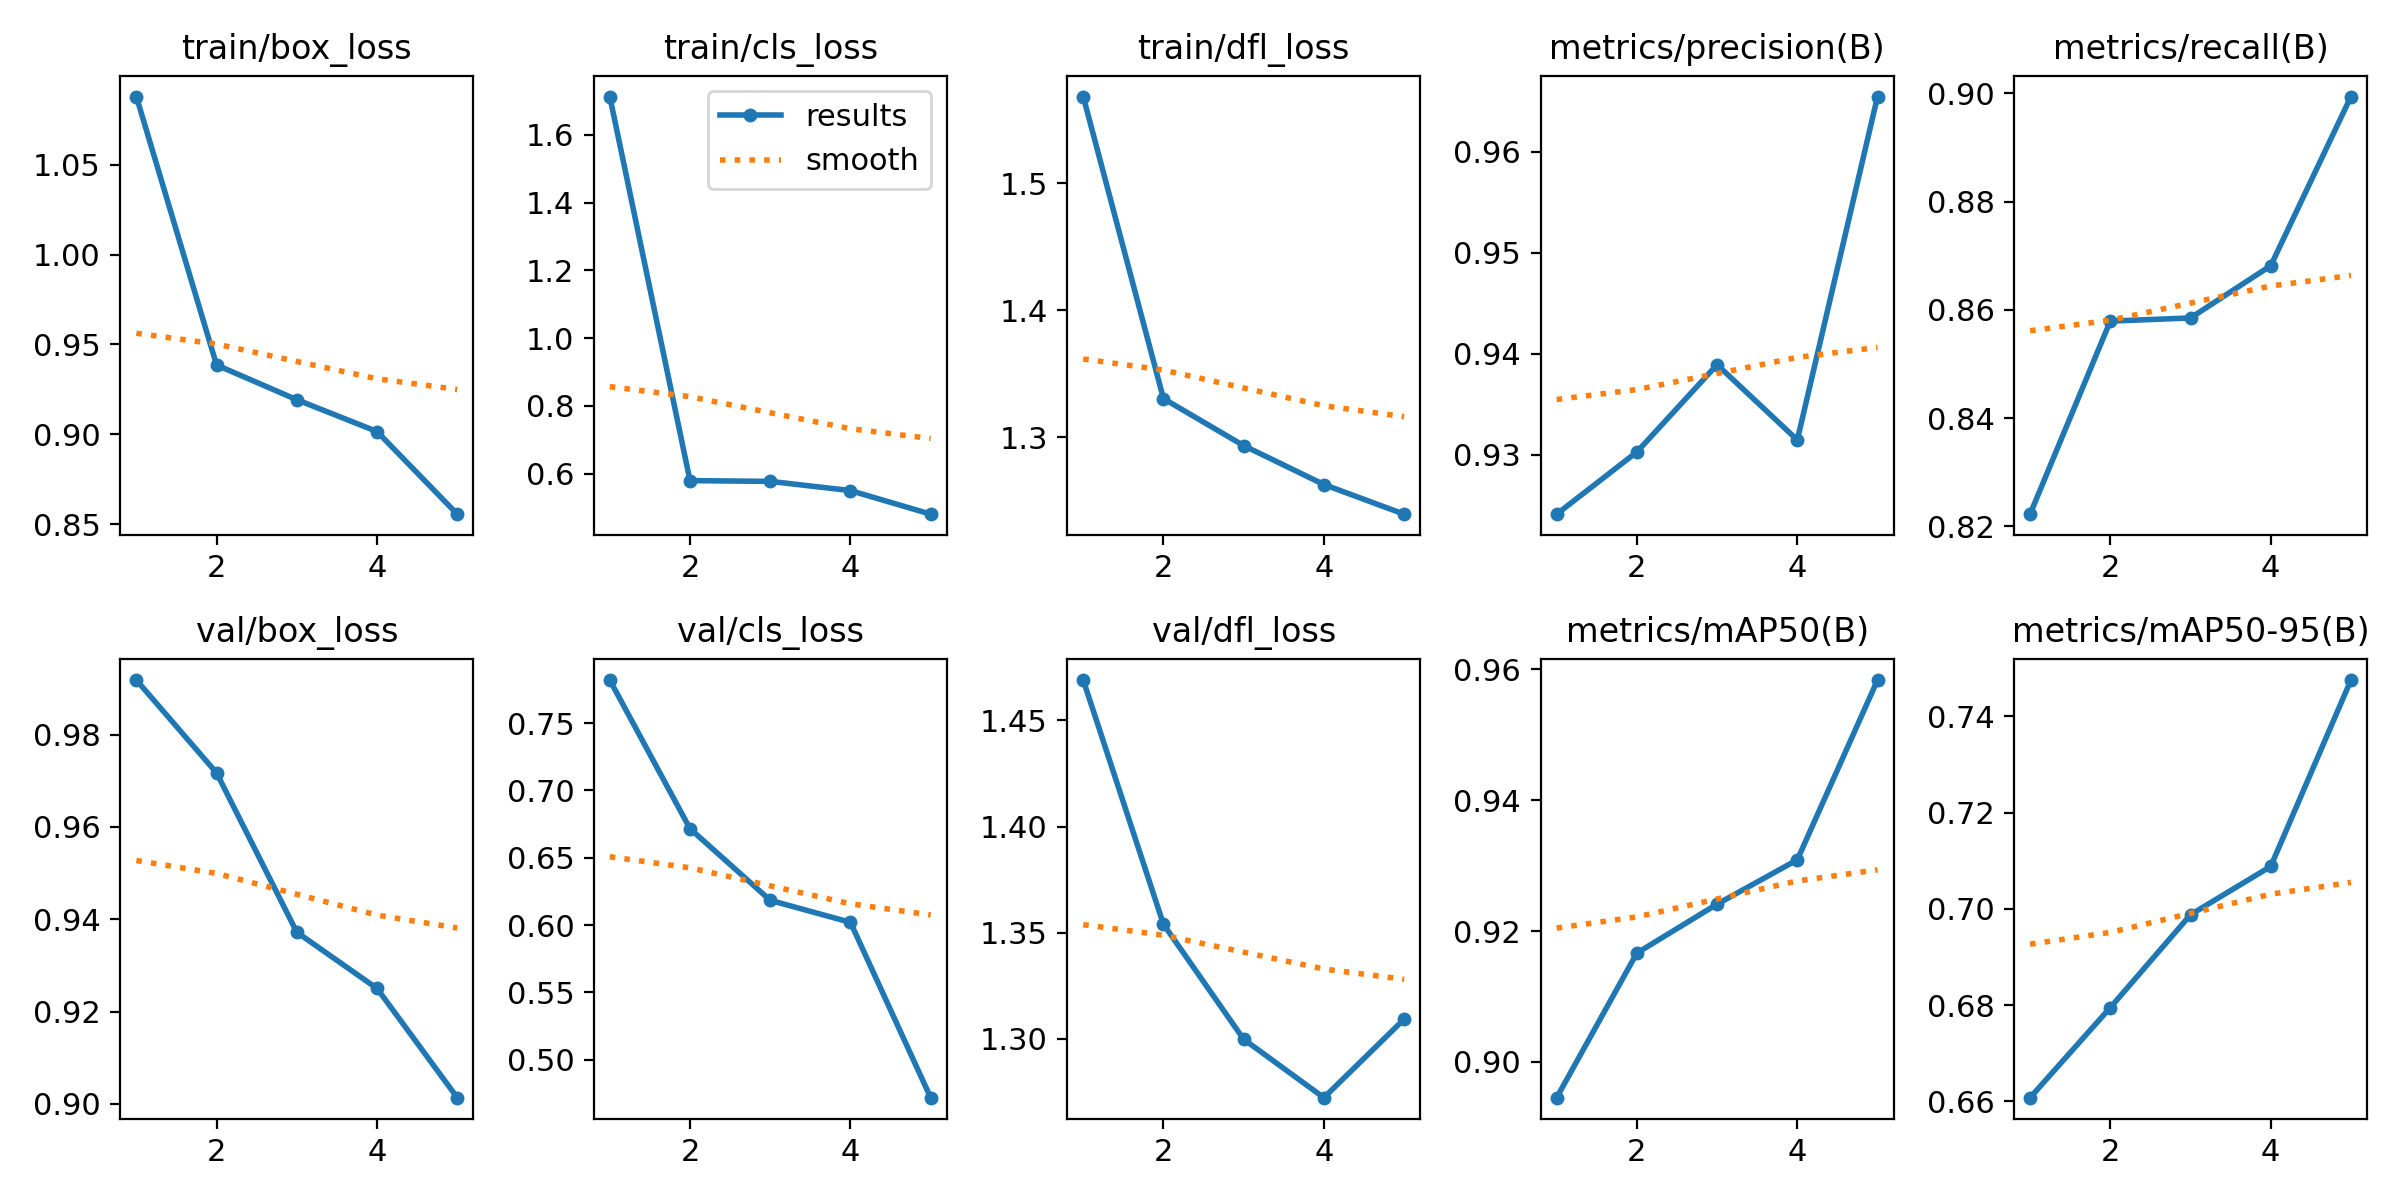

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/{RUNS}/results.png', width=600)

## Inference with Custom Model

In [ ]:
from ultralytics import YOLOE, YOLO
import supervision as sv

model = YOLOE(f'{HOME}/{RUNS}/weights/best.pt')
yolov8l = YOLO("yolov8l.yaml")

# After fine tuning, YOLOE is exactly the same as YOLOv8 or YOLO11
model.fuse()
# YOLOv8-L has more parameters because its nc is 80.
yolov8l.fuse()

YOLOe-v8l summary (fused): 273 layers, 43,607,379 parameters, 0 gradients, 164.8 GFLOPs
YOLOv8l summary (fused): 268 layers, 43,668,288 parameters, 43,668,272 gradients, 165.2 GFLOPs


**NOTE:** Let's start by loading our newly trained model.

In [ ]:
dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/valid/images",
    annotations_directory_path=f"{dataset.location}/valid/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


**NOTE:** Let's randomly select an image from our validation set and visualize the results.

SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.
SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.



0: 640x640 1 tumor, 77.9ms
Speed: 3.3ms preprocess, 77.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


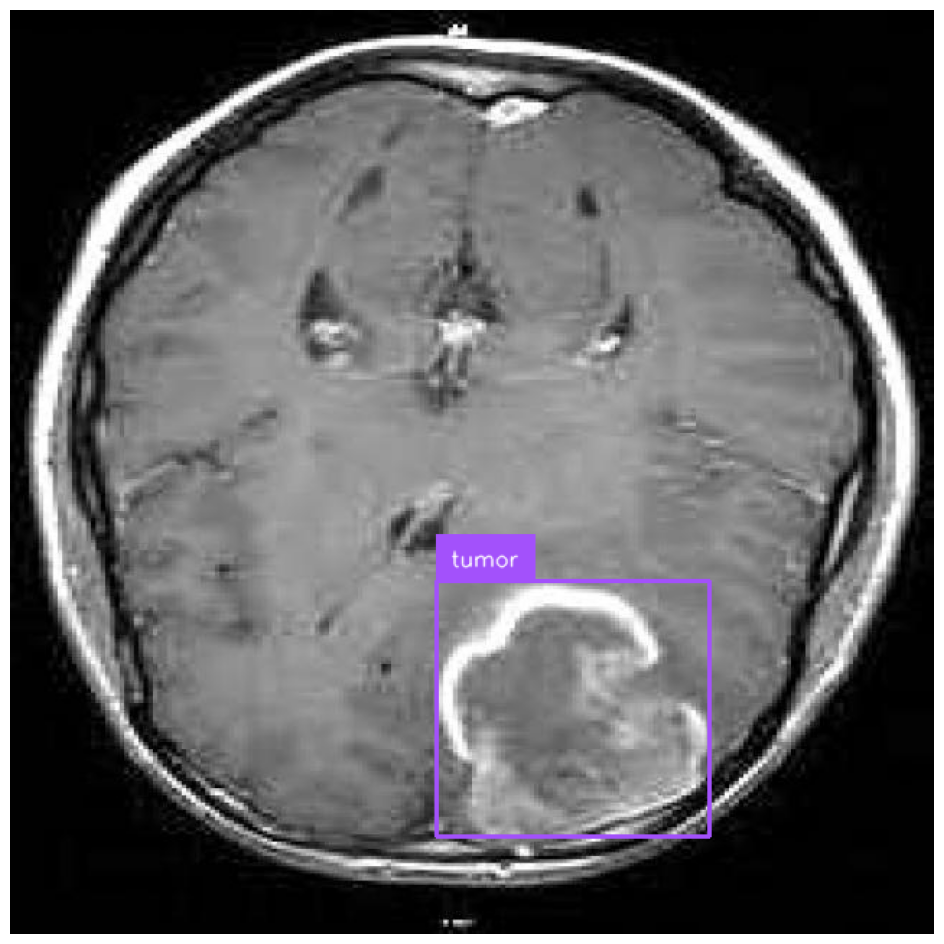

In [ ]:
import random

random_image = random.choice(list(dataset.images.keys()))
random_image = dataset.images[random_image]

results = model.predict(source=random_image, conf=0.05)[0]
detections = sv.Detections.from_ultralytics(results)

annotated_image = bounding_box_annotator.annotate(
    scene=random_image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)